# Two task network 

## Network has some inputs

1. The fixation. 
1. The first context mod. 
1. The second ontext mod. 

## Network has five outputs
1. The fixation. 
1. The first output.
1. The second output




<div>
<img src="./images/Sheme.png" width="300"/>
</div>

> Learning rule: superspike

> Neuron type: Lif + refrac

> Task: romo and dm task. 


In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt  # for analys
from cgtasknet.net.lifrefrac import SNNLifRefrac
from cgtasknet.tasks.reduce import MultyReduceTasks, DefaultParams
from norse.torch.functional.lif_refrac import LIFRefracParameters
from norse.torch.functional.lif import LIFParameters

# from norse.torch import LIF


## Step -1: Create dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')


Device: gpu (cuda)


In [3]:
batch_size = 30
number_of_tasks = 4
romo_parameters = DefaultParams("RomoTask").generate_params()
romo_parameters["delay"] = 0.1
romo_parameters["trial_time"] = 0.15
romo_parameters["n_mods"] = 1

dm_parameters = DefaultParams("DMTask").generate_params()
dm_parameters["n_mods"] = 1
task_list = ["RomoTask1", "DMTask1"]

tasks_parameters = dict(
    [
        (task_list[0], romo_parameters),
        (task_list[1], dm_parameters),
    ]
)

Task = MultyReduceTasks(
    tasks=tasks_parameters,
    batch_size=batch_size,
    number_of_inputs=1,
    delay_between_trial=500,
)
Task_test = MultyReduceTasks(
    tasks=tasks_parameters, batch_size=1, number_of_inputs=1, delay_between_trial=500
)


## Step 1.1: Create model

In [4]:
feature_size, output_size = Task.feature_and_act_size
hidden_size = 400

neuron_parameters = LIFRefracParameters(
    LIFParameters(
        tau_mem_inv=torch.as_tensor(1 / 0.01).to(device),
        alpha=torch.as_tensor(100),
        method="super",
        v_th=torch.as_tensor(0.65).to(device),
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
).to(device)


## Step 1.2: Save pre-learning weights

In [5]:
weights_pre_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())


## Step 2: loss and creterion 

In [6]:
learning_rate = 1e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


## Step 3: Train loop

In [7]:
%matplotlib
plt.ion
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("lif")
inputs, target_outputs = Task.dataset(number_of_tasks)
(line1,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line2,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line3,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line4,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([0, len(inputs)])
running_loss = 0
fig.canvas.draw()
fig.canvas.flush_events()
for i in range(4000):
    inputs, target_outputs = Task.dataset(number_of_tasks)
    # inputs = inputs * 2 - 1
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
    # with torch.no_grad():
    #    inputs[:, :, 1:3] = layer_inputs(inputs[:, :, 1:3])[0]
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = Task_test.dataset(number_of_tasks)

            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion(outputs, target_outputs)

            print("test loss: {:0.5f}".format(loss.item()))
        for_plot = outputs.detach().cpu().numpy()[:, 0, :]
        line1.set_xdata(np.arange(0, len(for_plot), 1))
        line2.set_xdata(np.arange(0, len(for_plot), 1))
        line3.set_xdata(np.arange(0, len(for_plot), 1))
        line4.set_xdata(np.arange(0, len(for_plot), 1))

        line1.set_ydata(for_plot[:, 1])
        line2.set_ydata(for_plot[:, 2])
        line3.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 1])
        line4.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 2])
    fig.canvas.draw()
    fig.canvas.flush_events()
print("Finished Training")

Using matplotlib backend: TkAgg
epoch: 10 loss: 0.15095
test loss: 0.09267
epoch: 20 loss: 0.08291
test loss: 0.07117
epoch: 30 loss: 0.05806
test loss: 0.04796
epoch: 40 loss: 0.04508
test loss: 0.03046
epoch: 50 loss: 0.03862
test loss: 0.03750
epoch: 60 loss: 0.03790
test loss: 0.04039
epoch: 70 loss: 0.03404
test loss: 0.03365
epoch: 80 loss: 0.03447
test loss: 0.03826
epoch: 90 loss: 0.03485
test loss: 0.03378
epoch: 100 loss: 0.03409
test loss: 0.03687
epoch: 110 loss: 0.03584
test loss: 0.03148
epoch: 120 loss: 0.03539
test loss: 0.03041
epoch: 130 loss: 0.03538
test loss: 0.02445
epoch: 140 loss: 0.03486
test loss: 0.03152
epoch: 150 loss: 0.03580
test loss: 0.03764
epoch: 160 loss: 0.03299
test loss: 0.03300
epoch: 170 loss: 0.03276
test loss: 0.03301
epoch: 180 loss: 0.03420
test loss: 0.03596
epoch: 190 loss: 0.03454
test loss: 0.02594
epoch: 200 loss: 0.03133
test loss: 0.03750
epoch: 210 loss: 0.02891
test loss: 0.01562
epoch: 220 loss: 0.01937
test loss: 0.04135
epoch: 23

In [ ]:
# torch.save(model.state_dict(), "Only_romo_lif_refrac_net")


In [ ]:
if False:
    model.load_state_dict(torch.load("Only_dm_lif_net"))


In [ ]:
inputs, target_outputs = Task_test.dataset(30)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs, states = model(inputs)


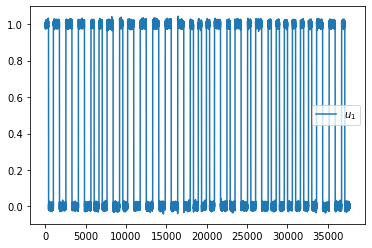

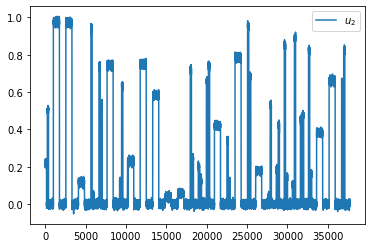

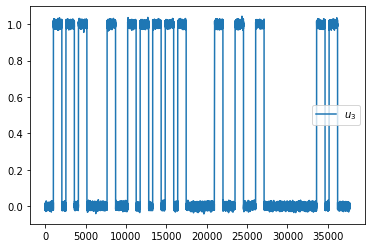

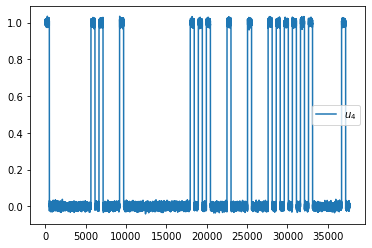

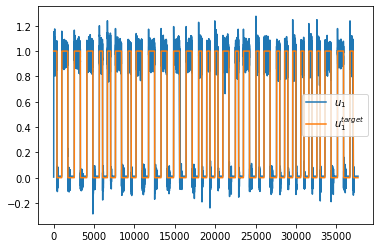

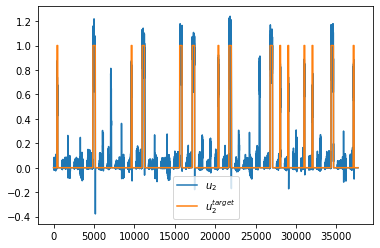

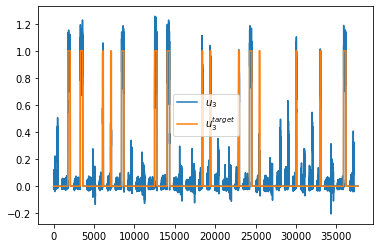

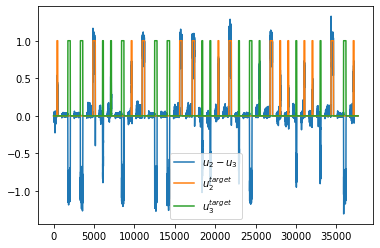

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.legend()
    plt.show()
    plt.close()
for i in range(outputs.shape[2]):
    plt.plot(outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.plot(
        target_outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u^{{target}}_{i + 1}$"
    )
    plt.legend()
    plt.show()
    plt.close()

plt.plot(
    outputs[:, 0, -2].detach().cpu().numpy() - outputs[:, 0, -1].detach().cpu().numpy(),
    label=fr"$u_2 - u_3$",
)
plt.plot(target_outputs[:, 0, -2].detach().cpu().numpy(), label=fr"$u^{{target}}_{2}$")
plt.plot(target_outputs[:, 0, -1].detach().cpu().numpy(), label=fr"$u^{{target}}_{3}$")
plt.legend()
plt.show()
plt.close()

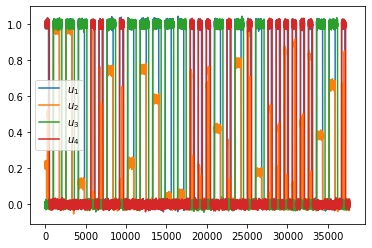

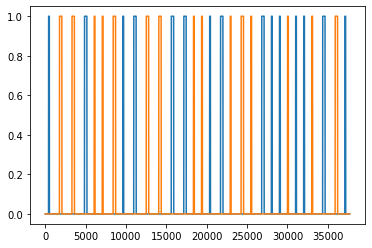

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")

plt.legend()
plt.show()
plt.close()
plt.plot(target_outputs[:, 0, 1].detach().cpu().numpy(), label=fr"$y_{2}$")
plt.plot(target_outputs[:, 0, 2].detach().cpu().numpy(), label=fr"$y_{3}$")

In [ ]:
weights_post_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_post_l.append((param).cpu().numpy())


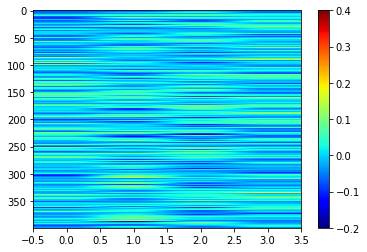

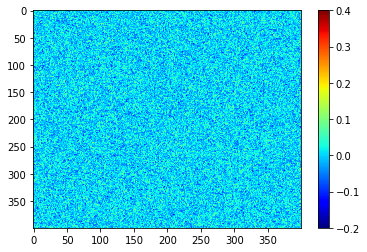

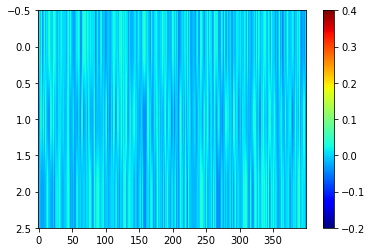

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow((weights_pre_l[i]), aspect="auto", cmap="jet", vmin=-0.2, vmax=0.4)
    plt.colorbar()
    plt.show()

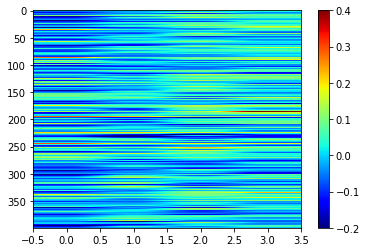

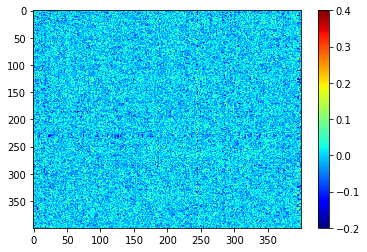

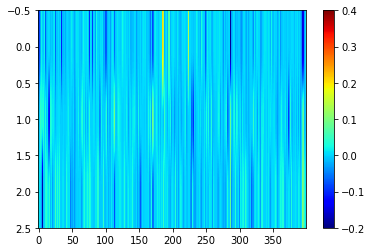

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow((weights_post_l[i]), aspect="auto", cmap="jet", vmin=-0.2, vmax=0.4)
    plt.colorbar()
    plt.show()

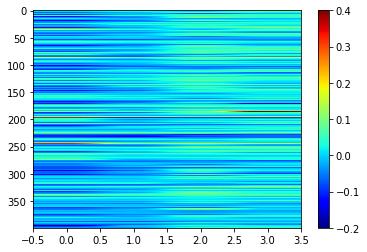

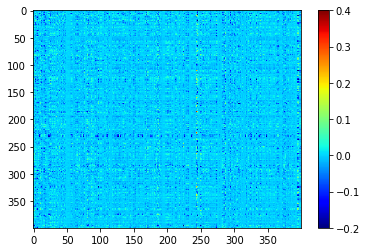

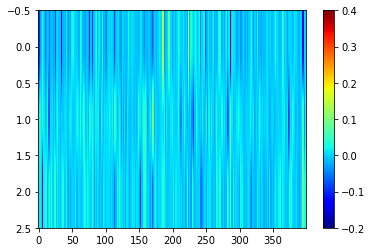

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l) - 1):
    plt.imshow(
        (weights_post_l[i] - weights_pre_l[i]),
        aspect="auto",
        cmap="jet",
        vmin=-0.2,
        vmax=0.4,
    )
    plt.colorbar()
    plt.show()